In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
import copy

In [76]:
%matplotlib inline

## Examen de biostatistique : Etude du cancer de la prostate
## Ouverture du fichier

In [2]:
file = pd.read_csv('prostate.txt',sep=" ")
df = pd.DataFrame(file)

In [3]:
print(df)

     y        X1        X2        X3        X4        X5        X6        X7  \
1    0 -0.927178 -0.740039 -0.532016 -1.097891 -0.986673  0.018752 -0.863326   
2    0 -0.835899 -0.835899 -0.585647 -0.835899 -0.329768 -0.835899 -0.835899   
3    0  0.236073  0.252645 -1.154351 -0.372372 -0.338900  1.253467  0.506325   
4    0 -0.748623 -0.439165  0.790953 -1.033876  0.241115  1.216007  0.106282   
5    0  0.101239 -0.298285 -1.121519 -0.957714  0.342258  1.182937  0.029325   
6    0 -0.319511 -0.106289 -1.085658 -0.997987  0.607362  0.212231 -0.280363   
7    0  0.139263 -0.161709  0.537001 -1.177818  0.908153  0.682660 -0.631557   
8    0 -0.074273 -0.702714  0.048901 -1.089233  0.232284  0.131847 -1.089233   
9    0  0.664819 -0.098865 -1.146821 -0.412885 -1.070479  1.310646 -0.721795   
10   0  0.312973 -0.183571 -1.154732 -1.154732 -0.325427  1.338133  0.641860   
11   0 -0.780733 -0.956725 -0.864723 -0.956725 -0.780733  0.103749 -0.631933   
12   0 -0.277425 -0.660388 -1.104309 -1.

[102 rows x 6034 columns]


In [4]:
genes = df.values[:,1:]
diagnostic = df.values[:,:1]

## Analyse en composantes principales
On ne peut pas se limiter aux composantes ayant la plus grande variance. On est obligé de procéder d'une autre manière pour séparer les cas, étant donnés que les composantes principales ne sont pas séparables linéairement (et même non linéairement).

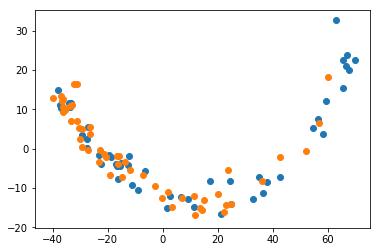

In [5]:
decompose = PCA(n_components=2)
comp = decompose.fit_transform(genes)

plt.scatter(comp[:50,0],comp[:50,1])
plt.scatter(comp[50:,0],comp[50:,1])
plt.show()

In [6]:
genescomp = decompose.components_
normscomp = genescomp[0,:]**2 + genescomp[1,:]**2
bestgenes = normscomp.argsort()[-10:][::-1]
print("Les genes participant le plus aux 2 composantes principales sont les suivants:")
print(bestgenes)

Les genes participant le plus aux 2 composantes principales sont les suivants:
[5172  126  526 3401 3399  437 3617  250  308  306]


## Analyse massivement univariée des gènes différentiateurs
Ici, on réalise des tests ANOVA sur chacun des genes, par rapport au diagnostic. On utilise directement la fonction f_classif de scikit-learn, et on sélectionne les 2% de genes qui sont exprimées 'le plus différentiellement', ie qui ont la plus petit p-valeur pour le test (on affiche -log(pvalue), normalisée, pour que le graphique soit plus significatif).
On observe que les meilleurs genes sont bien différents de ceux ayant la variance la plus importante (qui participent donc le plus aux composantes principales)
Enfin, en appliquant une correction de type bonferroni, on réduit les genes differentiateurs de plus de 5000 à seulement 317

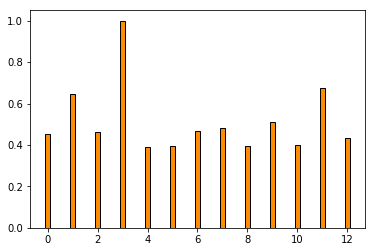

Les genes qui sont le plus différentiées selon me diagnostic sont: 
[1639 1838 2424 2618 2745 3704 3933 4154 4211 4700 4848 5015 5807]


In [65]:
selector = SelectPercentile(f_classif, percentile=0.2)
bestgenes = selector.fit_transform(genes, diagnostic.ravel())
mask = selector.get_support()
scores = -np.log10(selector.pvalues_[mask])
scores /= scores.max()
X_indices = np.arange(bestgenes.shape[-1])
plt.figure()
plt.bar(X_indices, scores, width=.2,
        label=r'Score par analyse univariée ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
plt.show()
indices = selector.get_support(True)
print("Les genes qui sont le plus différentiées selon le diagnostic sont: ")
print(indices)

In [77]:
Fvalues,pvalues = f_classif(genes,diagnostic.ravel())
print('Genes differentiellement exprimés avant correction')
mask1 = pvalues<0.95
print(np.sum(mask1))
pvalues *= genes.shape[1]
pvalues[pvalues>1] = 1.0
mask = pvalues<0.95
print('Genes differentiellement exprimés après correction (bonferroni)')
print(np.sum(mask))

Genes differentiellement exprimés avant correction
5914
Genes differentiellement exprimés après correction (bonferroni)
371


### Régression sPLS

On peut réécrire $Cov(Xa,y)$ En effet:
\begin{align*}
Cov(Xa,y) & = \frac{1}{n}\sum_{i=1}^{n} \left(\sum_{j=1}^{n} X_{ij}a_j\right)y_i \\
  & =\frac{1}{n} \sum_{i=1}^{n}\sum_{j=1}^{n} X_{ij}a_j y_i \\
  & =\frac{1}{n} \sum_{j=1}^{n}\sum_{i=1}^{n} X_{ij}a_j y_i \\
  & =\sum_{j=1}^{n}a_j \left(\frac{1}{n} \sum_{i=1}^{n} X_{ij} y_i\right) \\
  & = a^T(\frac{1}{n}X^Ty)
\end{align*}

Ensuite, le problème d'optimisation (1) peut se réécrire à l'aide du lagrangien:
\begin{equation}
\underset{y}{max}\ a^T(\frac{1}{n}X^Ty) _ \gamma ||a||^2_2 - \lambda ||a||_1 , \lambda \geq 0
\end{equation}
Ce qui est égal à:
\begin{equation}
\underset{y}{max} \sum_i a_i(\frac{1}{n}X^Ty)_i - \gamma a_i^2 - \lambda |a_i|
\end{equation}
Les termes sont tous indépendants 2 à 2, maximiser cette somme revient à maximiser chaque terme $ a_i(\frac{1}{n}X^Ty)_i - \gamma a_i^2 - \lambda |a_i|$.
On pose $\beta_i=(\frac{1}{n}X^Ty)_i$
On peut distinguer alors 2 cas:
* $\beta_i \geq 0$. On remarque que dans ce cas $a_i^*$ est positif aussi (si a_i est négatif, le terme est supérieur quand on prend $-a_i$.). On cherche donc à minimiser 
\begin{equation}
a_i*\beta_i+\gamma a_i + \lambda a_i
\end{equation}
On sait que la dérivée est nulle en un point critique, il vient
\begin{align*}
\beta_i -2\gamma a_i^* - \lambda &= 0 \\
a_i^* &= \frac{1}{2\gamma}(\beta_i - \lambda) \\
a_i^* &= \frac{1}{2\gamma}S(\beta_i,\lambda)
\end{align*}
On choisit $\gamma$ de manière à respecter la contrainte associée, et on retrouve la solution donnée.
* $\beta_i < 0$. Pour les mêmes rainsons que ci-dessus, $a_i^*$ est cette fois-ci négatif. Après calcul, il vient:
\begin{align*}
\beta_i -2\gamma a_i^* + \lambda &= 0 \\
a_i^* &= \frac{1}{2\gamma}(\beta_i + \lambda) \\
a_i^* &= \frac{1}{2\gamma}(\lambda - |\beta_i|) \\
a_i^* &= -\frac{1}{2\gamma}(|\beta_i|-\lambda) \\
a_i^* &= \frac{1}{2\gamma}S(\beta_i,\lambda)
\end{align*}
On choisit $\gamma$ de la même manière que précedemment, et on retrouve la solution.

In [6]:
def sPLS(X,y,lam):
    n = 1./y.shape[0]
    temp = n*np.dot(X.T,y)
    a = np.maximum(np.absolute(temp)-lam,0)
    a = np.sign(temp)*a
    norm = np.linalg.norm(a)
    if norm>0:
        a = a/np.linalg.norm(a)
    return a.flatten(), np.dot(X,a).flatten()

def PLSComponents(X,yprop,lam,n):
    y = yprop-np.mean(yprop)
    comp = np.zeros((n,X.shape[0]))
    residus = copy.deepcopy(X)
    vectors = np.zeros((n,X.shape[1]))
    for i in range(n):
        vectors[i,:],comp[i,:] = sPLS(residus,y,lam)
        y = y - comp[i,:].reshape((-1,1))
        residus = residus-np.outer(comp[i,:],vectors[i,:])
    return comp,vectors

## Application de l'algorithme sPLS
On remarque ici que la régression sPLS pour trouver des composants parcimonieuses donne en effet des variables visuellement plus séparables que les composantes principales. On remarque aussi que le paramètre $\lambda$ de sparsité ne peut aller au-delà de 0.1 environ.

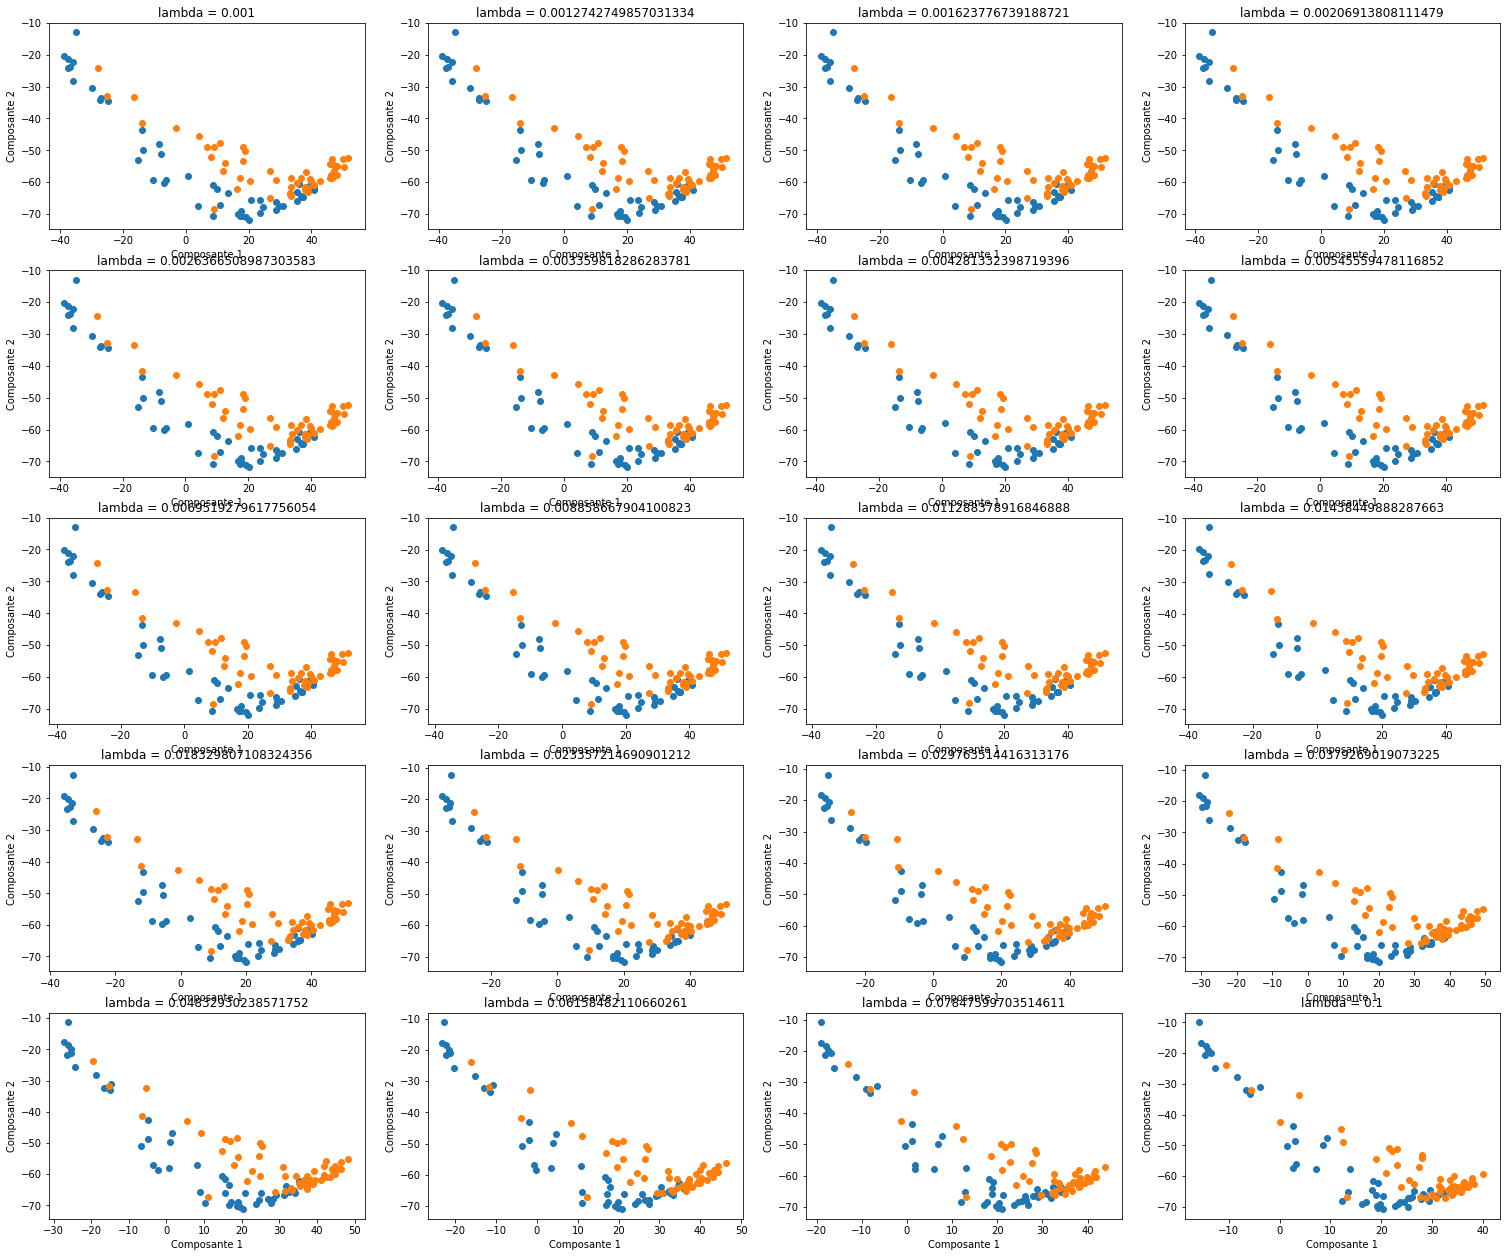

In [80]:
n = 20
lambdatests = np.logspace(-3,-1,20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(26,22))
for i in range(n):
    lam = lambdatests[i]
    genescompspls,vectorspls = PLSComponents(genes,diagnostic,lam,2)
    k = i//4
    j = i%4
    axes[k,j].scatter(genescompspls[0,:50],genescompspls[1,:50])
    axes[k,j].scatter(genescompspls[0,50:],genescompspls[1,50:])
    axes[k,j].set_xlabel("Composante 1")
    axes[k,j].set_ylabel("Composante 2")
    axes[k,j].set_title("lambda = "+str(lam))
plt.show()

## Analyse discriminante
On choisit une grille logarithmique pour le paramètre de sparsité. On cherche d'abord sur une grille le coupe (sparsité, nombre de composantes), puis on réalise un dichotomie sur le paramètre de sparsité pour en trouver un optimal

In [81]:
clf = LDA()
kf = StratifiedKFold(n_splits=5)
lambdas = np.logspace(-3,-1,50)
ncomps = range(2,18)
means = np.zeros((lambdas.shape[0],len(ncomps)))
stds = np.zeros((lambdas.shape[0],len(ncomps)))
k=0
for lam in tqdm(lambdas,'Cross validation'):
    i=0
    for n in ncomps:
        scores = []
        for train_index, test_index in kf.split(genes,diagnostic):
            traincomps,vectorcomps = PLSComponents(genes[train_index,:],diagnostic[train_index],lam,n)
            testcomps = np.dot(genes[test_index,:],vectorcomps.T)
            clf.fit(traincomps.T,diagnostic[train_index].ravel())
            scores.append(clf.score(testcomps,diagnostic[test_index].ravel()))
        scores = np.array(scores)
        mean = np.mean(scores)
        std = np.std(scores)
        means[k,i] = mean
        stds[k,i] = std
        i+=1
    k+=1

Cross validation: 100%|██████████| 50/50 [06:06<00:00,  8.25s/it]


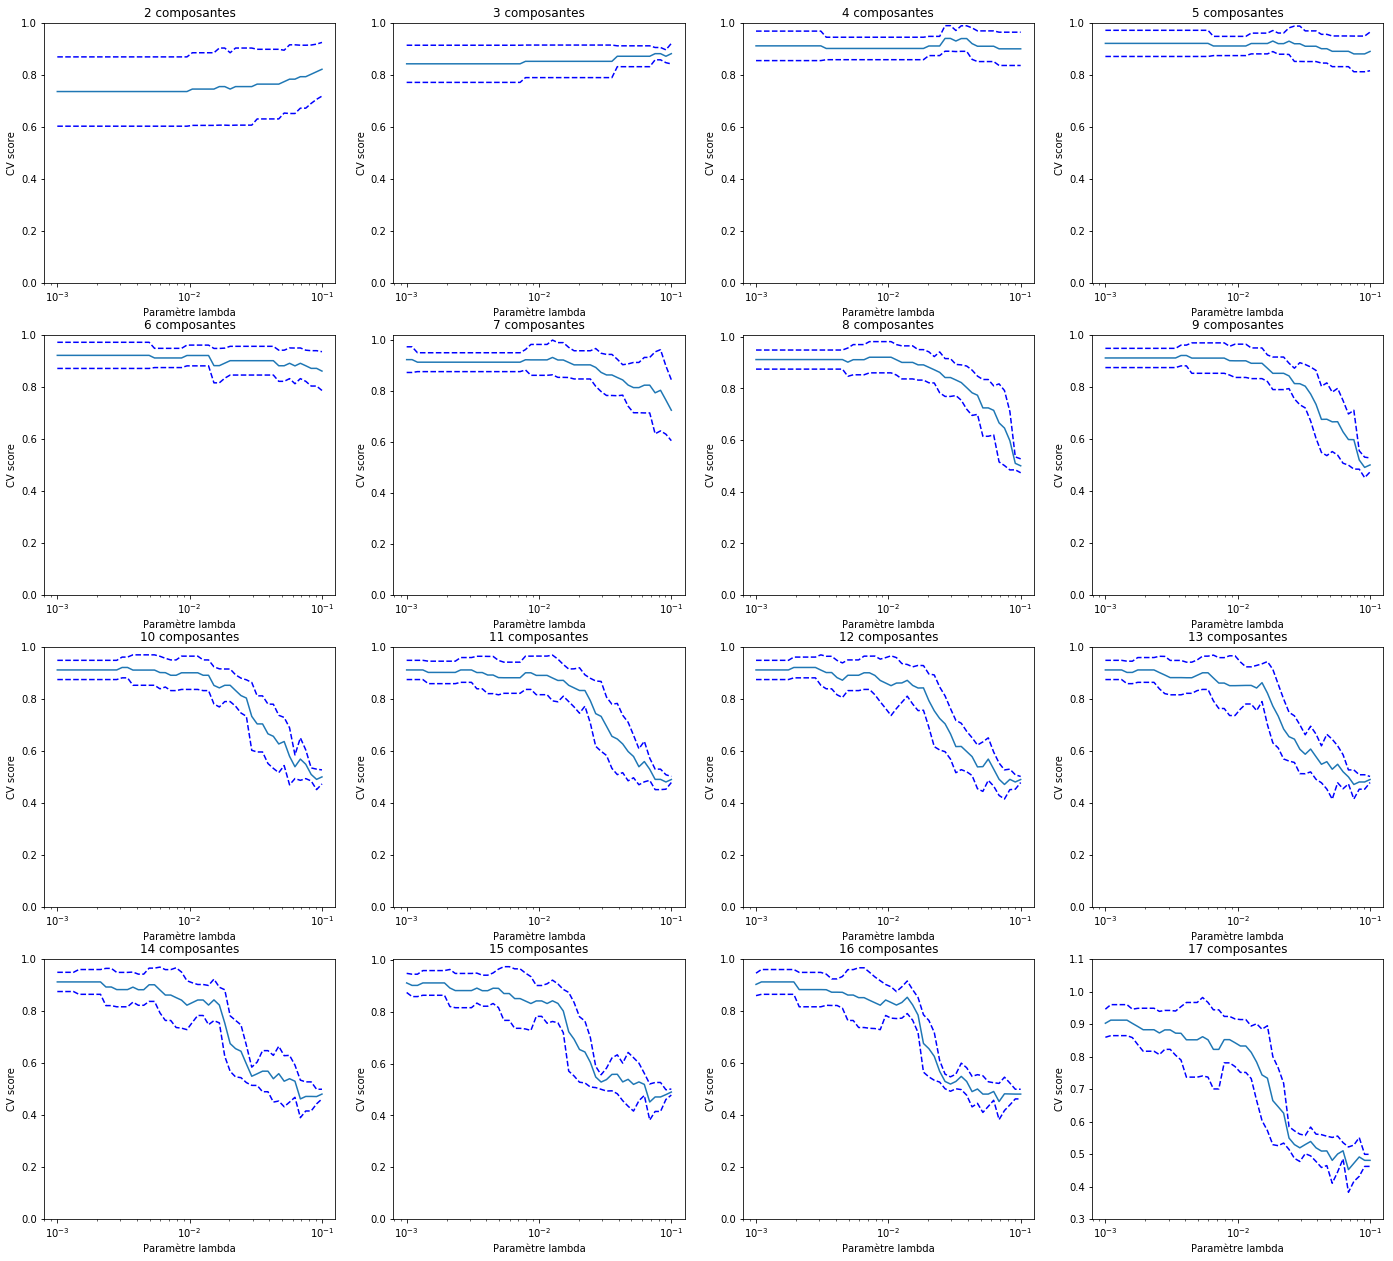

In [82]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24,22))
m = len(ncomps)
for i in range(m):
    k = i//4
    j = i%4
    axes[k,j].semilogx(lambdas, means[:,i])
    axes[k,j].semilogx(lambdas,means[:,i] + stds[:,i], 'b--')
    axes[k,j].semilogx(lambdas,means[:,i] - stds[:,i], 'b--')
    locs, labels = plt.yticks()
    axes[k,j].set_yticks(locs, list(map(lambda x: "%g" % x, locs)))
    axes[k,j].set_xlabel('Paramètre lambda')
    axes[k,j].set_ylabel('CV score')
    axes[k,j].set_title(str(ncomps[i])+" composantes")
plt.show()

In [83]:
indlam,bestn = np.unravel_index(means.argmax(), means.shape)
nombreideal = ncomps[bestn]
print("Meilleur score par validation croisée: "+str(means[indlam,bestn]))
print("Paramètre de sparsité retenu :"+str(lambdas[indlam]))
print("Nombre de composantes :" +str(nombreideal))

Meilleur score par validation croisée: 0.9409523809523808
Paramètre de sparsité retenu :0.026826957952797246
Nombre de composantes :4


In [94]:
traincomps,vectorcomps = PLSComponents(genes,diagnostic,lambdas[indlam],nombreideal)
clf.fit(traincomps.T,diagnostic.ravel())
weightscomps = np.zeros(genes.shape[1]) 
temp = traincomps.T*clf.coef_
for i in range(4):
    weightscomps += np.sum(np.outer(temp[:,i],vectorcomps[i,:])**2,axis=0)
bestgenes = weightscomps.argsort()[-10:][::-1]
print("Les genes participant le plus à la discrimination sont les suivants:")
print(bestgenes)

Les genes participant le plus aux 2 composantes principales sont les suivants:
[1838 4700 2618 5015 4154 5981 4334 3664 2424 4287]


## Modèle de régression logistique pénalisée L1
Ici, on réalise aussi une recherche sur une grille logarithmique pour le paramètre de sparsité.

In [56]:
logregclf = LogisticRegression(penalty='l1',solver='liblinear')
kf = StratifiedKFold(n_splits=5)
allCs = np.logspace(-3,3,1000)
scores_m = []
scores_std = [] 
for C in tqdm(allCs,"Validation croisée en cours"):
    logregclf.C = C
    scores = []
    for train_index, test_index in kf.split(genes,diagnostic):
        logregclf.fit(genes[train_index,:],diagnostic[train_index].ravel())
        scores.append(clf.score(genes[test_index,:],diagnostic[test_index].ravel()))
    scores = np.array(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    scores_m.append(mean)
    scores_std.append(std)

Validation croisée en cours: 100%|██████████| 1000/1000 [03:35<00:00,  3.32it/s]


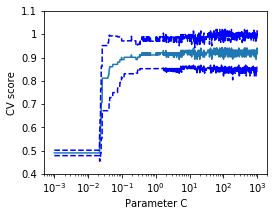

In [75]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(allCs, scores_m)
plt.semilogx(allCs, np.array(scores_m) + np.array(scores_std), 'b--')
plt.semilogx(allCs, np.array(scores_m) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.show()

In [22]:
indice = np.argmax(scores_m)
bestC = allCs[indice]
print("Meilleur score par validation croisée: "+str(scores_m[indice]))
print("Paramètre de sparsité retenu :"+str(1./bestC))

Meilleur score par validation croisée: 0.9504761904761905
Paramètre de sparsité retenu :0.008529644499741017


In [99]:
logregclf = LogisticRegression(penalty='l1',solver='liblinear',C=bestC)
logregclf.fit(genes,diagnostic.ravel())
weightslog = logregclf.coef_**2
bestgenes = weightslog.ravel().argsort()[-10:][::-1]
print("Les genes participant le plus à la régression logistique sont les suivants:")
print(bestgenes)

Les genes participant le plus à la régression logistique sont les suivants:
[ 466 5015  182 1734 2618 4571 2387 5448 2376 3119]


On remarque que les résultats sont sensiblement les mêmes pour le score par validation croisée, et certains genes utilisés dans la régression sPLS + analyse discriminante se retrouvent ensuite dans celle dans la regression logistique. Cela s'explique par la proximité des deux problèmes résolus (dans la régression logistique, on travaille $X^Ty$, et on ajoute une pénalité $L_1$).